# Overview

## Literally the same as the previous notebook...
Again, we are trying to predict metallicity using RGB images from SDSS spectroscopic and photometric observations, respectively. I'm going to use Leslie Smith's idea of [first increasing and then decreasing the learning rate](https://arxiv.org/abs/1708.07120), which is becoming popularized by [fast.ai](http://forums.fast.ai/t/the-1cycle-policy-an-experiment-that-investigate-super-convergence-phenomenon-described-in-leslie-smiths-research/14737) and [Sylvain Gugger](https://sgugger.github.io/the-1cycle-policy.html). 

Here's an example of what to do with the learning rate + momentum:

![](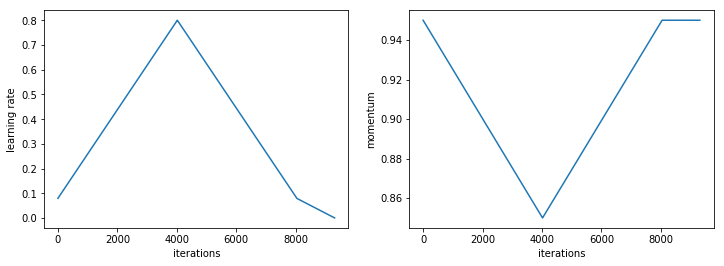%0A)

# Imports and other necessary functions

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display


In [2]:
PATH = os.path.abspath('..')

In [5]:
torch.cuda.set_device(1)

In [3]:
def parse_csv_multi_class_values(path_to_csv):
    """Parse filenames and values for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of values in the same order
            a dictionary of classes by classIndex           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    values = [vals for _, *vals in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, values, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, values, idx2class = parse_csv_multi_class_values(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    val_arr = np.array(values).astype(np.float32)
    
    return full_names, val_arr, idx2class

@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

# Set up the network, metric, and data

In [4]:
train_label_csv = f'{PATH}/catalogs/train-metaldist.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)

# test-val split
val_idxs = get_cv_idxs(n)

## Use half-size images

In [6]:
sz = 64
bs = 64
arch = resnext101_64

def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.5)
    return ImageClassifierData.from_multiclass_csv(PATH, 'images', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=8)

In [7]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data)

In [8]:
def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

metrics = [rmse]
learn.crit = rmse

 88%|████████▊ | 1056/1200 [02:06<00:17,  8.35it/s, loss=2.25] 

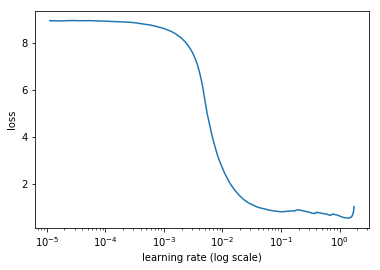

In [9]:
learn.lr_find()
learn.sched.plot()

# Training time

Okay, so remember here that the goal is to settle into a broader well *over a number of epochs* rather than to get wedged into a local minimum near by the starting point. This is the goal of SGDR (stochastic gradient descent with restarts) as well, except here we aren't even going to explore the narrow and steep local minima. The fact that we are increasing our learning rate for so long means that we are constantly trying to avoid overfitting.

In [10]:
lr = 0.15           # maximum lr
lr_factor = 10      # minimum lr = lr/lr_factor
lr_anneal_pct = 10. # percentage of cycle to cosine anneal

cycle_len = 90

momentum_max = 0.95 # maximum of momentum (when at min lr)
momentum_min = 0.85 # minimum of momentum (when at max lr)

In [11]:
learn.unfreeze()

lrs = lr * np.array([1e-2, 1e-1, 1])

In [12]:
learn.fit(lrs, 1, cycle_len=cycle_len, use_clr_beta=(lr_factor, lr_anneal_pct, momentum_max, momentum_min))

epoch      trn_loss   val_loss                                 
    0      0.281038   0.148196  
    1      0.167968   0.130732                                 
    2      0.125365   0.120245                                 
    3      0.116088   0.107886                                 
    4      0.11676    0.107769                                 
    5      0.114094   0.104806                                 
    6      0.117067   0.107737                                 
    7      0.113116   0.104757                                 
    8      0.111679   0.105955                                 
    9      0.114186   0.105613                                 
    10     0.113491   0.104388                                 
    11     0.112612   0.10475                                  
    12     0.109685   0.099879                                 
    13     0.110848   0.102196                                 
    14     0.107339   0.100241                                 
    15 

[array([0.09627])]

In [13]:
learn.save('resnext101-CLR-init')

In [16]:
np.save(f'{PATH}/tmp/resnext101-CLR_val_losses.npy', learn.sched.val_losses)
np.save(f'{PATH}/tmp/resnext101-CLR_trn_losses.npy', learn.sched.losses)

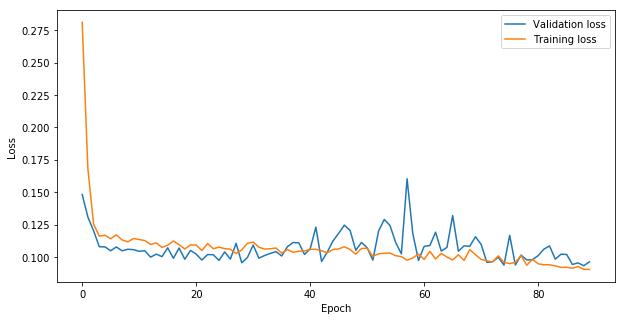

In [14]:
fig,ax = plt.subplots(1,1, figsize=(10, 5))
ax.plot(list(range(cycle_len)),learn.sched.val_losses, label='Validation loss')
ax.plot(list(range(cycle_len)),[learn.sched.losses[i] for i in range(1199, cycle_len*1200, 1200)], label='Training loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')